In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import gdown

# totalVI

## Load the dataset

In [2]:
gdown.download(
    'https://drive.google.com/uc?id=1mXikpKDZ6Nqh42kDHHbwVeMJWc1V9mdB',
    'gayoso2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1mXikpKDZ6Nqh42kDHHbwVeMJWc1V9mdB
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/gayoso2020-expressions.h5ad
204MB [00:01, 119MB/s]  


'gayoso2020-expressions.h5ad'

In [3]:
scrna = sc.read_h5ad('gayoso2020-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 30293 × 4000
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1Y4wyzhaXrmW1anoByA5clmzrY6OurL4R',
    'gayoso2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1Y4wyzhaXrmW1anoByA5clmzrY6OurL4R
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/gayoso2020-proteins.h5ad
57.4MB [00:00, 206MB/s]


'gayoso2020-proteins.h5ad'

In [5]:
cite = sc.read_h5ad('gayoso2020-proteins.h5ad')
cite

AnnData object with n_obs × n_vars = 30293 × 110
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [6]:
# scvi needs one adata, so we merge rna and cite
adata = scrna
adata.X = scrna.layers['count']
adata.obsm['proteins'] = cite.layers['count']

In [7]:
scvi.data.setup_anndata(adata, batch_key='batch_indices', labels_key='cell_types', protein_expression_obsm_key='proteins')

INFO     Using batches from adata.obs["batch_indices"]                                       
INFO     Using labels from adata.obs["cell_types"]                                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['proteins']                                
INFO     Generating sequential protein names                                                 
INFO     Successfully registered anndata object containing 30293 cells, 4000 genes, 2        
         batches, 27 labels, and 110 proteins. Also registered 0 extra categorical covariates
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [8]:
vae = scvi.model.TOTALVI(
    adata,
    latent_distribution="normal",
    n_layers_decoder=2
)

In [9]:
vae.train(n_epochs=100)

INFO     KL warmup phase may exceed overall training phase.If your applications rely on      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 22719.75 iterations                                                   


Output()

INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  398 s. / 100 epochs                                                 


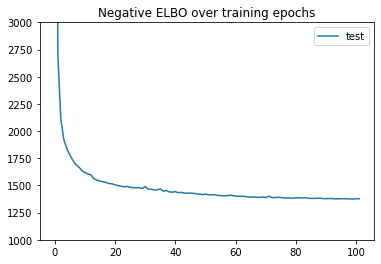

In [10]:
plt.plot(vae.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1000, 3000)
plt.legend()

In [11]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

In [20]:
z = sc.AnnData(adata.obsm["X_totalVI"])
z.obs = adata.obs

In [21]:
z.write('../data/integrated/totalvi/gayoso-totalvi.h5ad')

In [23]:
!rm 'gayoso2020-expressions.h5ad'
!rm 'gayoso2020-proteins.h5ad'

## Visualize results

In [25]:
sc.pp.neighbors(z)
sc.tl.umap(z)

In [26]:
z.obs['batch_indices'] = z.obs['batch_indices'].astype('category')

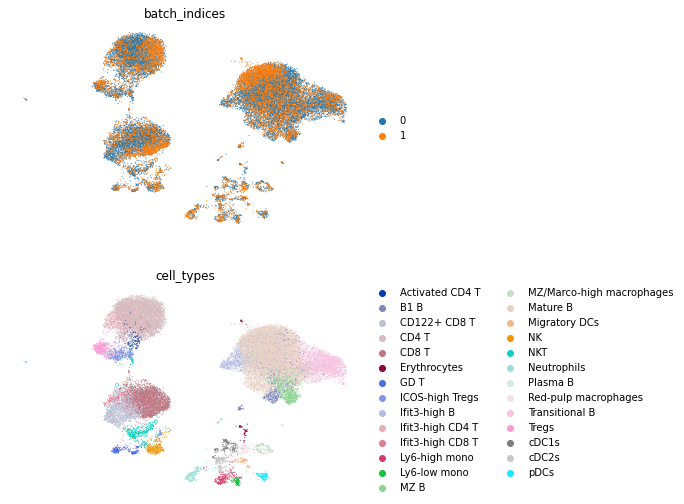

In [27]:
sc.pl.umap(z, color=['batch_indices', 'cell_types'], ncols=1, frameon=False)